# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 6 декабря 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 6 декабря, -4 балла после 06:00 13 декабря, -6 баллов после 06:00 20 декабря

При отправлении ДЗ указывайте фамилию в названии файла

Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush Необходимо в slack создать таск в приватный чат:
/todo Фамилия Имя ссылка на гитхаб @alkhamush
Пример:
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [2]:
USER_NAME = u"Афанасьева".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print "Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
)

Имплементируйте обучение логистической регрессии с L2 регуляризацией с помощью метода Mini Batch Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту, т.е. в алгоритме надо
    * Перемешать выборку
    * Посчтитать градиент на одном объекте
    * Сделать шаг спуска
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Почитать градиент по мини батчам
    * Сделать шаг спуска
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в обучающей выборке (тем или иным способом)

# Реализация модели

## Имплементация (6 баллов)

In [3]:
def demo_sigmoid():
    z = np.linspace(-10, 10, 100)

    y = sigmoid(z)
    plt.plot(z, y)
    plt.xlabel('$z$')
    plt.ylabel('$\sigma(z)$')
    
def sigmoid(z): 
    return 1./(1+np.exp(-z))

Перед тем как мы начнем, рассмотрим функцию $$\sigma(z) = \frac{1}{1 + exp{(-z)}},$$она называется **сигмойда**. 

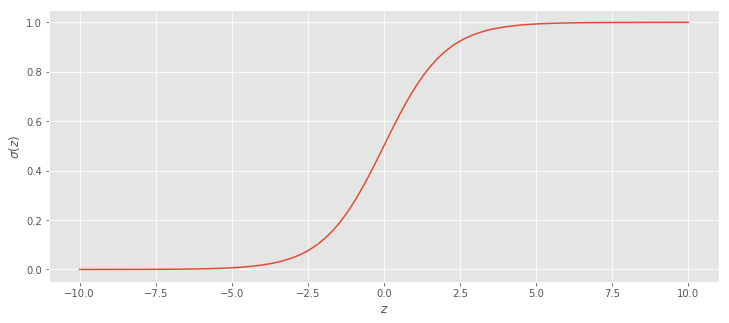

In [4]:
demo_sigmoid() 

Будем требовать, чтобы алгоритм возвращал вероятность класса $y=+1$:
$$h(x,w) = p(y=+1|x,w) = \sigma(g(x))$$

Выпишем функцию правдоподобия (c L2 регуляризацией)
$$ \mathcal{L}(w) = \prod_i^n h(x^{(i)},w)^{[y^{(i)} = +1]} (1 - h(x^{(i)},w))^{[y^{(i)} = -1]} \rightarrow \max_w$$
$$ -\log{\mathcal{L}(w)} = - \sum_i^n [y^{(i)} = +1]\cdot\log{(h(x^{(i)},w))} + {[y^{(i)} = -1]}\cdot\log{(1-h(x^{(i)},w))} \rightarrow \min_w$$
$$L(w) = \log{\mathcal{L}(w)} \rightarrow \min_w $$

В обоих случаях может помочь **регуляризация** - добавление штрафного слагаемого за сложность модели в функцию потерь. В случае линейной регрессии было:
$$ L(\beta_0,\beta_1,\dots) = \frac{1}{2n}\sum^{n}_{i=1}(a(x^{(i)}) - y^{(i)})^2 $$
Стало (Ridge Regularization)
$$ L(\beta_0,\beta_1,\dots) = \frac{1}{2n}\left[ \sum^{n}_{i=1}(a(x^{(i)}) - y^{(i)})^2\right] + \frac{1}{C}\sum_{j=1}^{m}\beta_j^2 $$

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, alpha=0.01, max_epoch=10, batch_size=10):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        batch_size - размер части (мини батча)
        """
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_size = batch_size
    
    def h (self, x_elem):
        return sigmoid(-1 * x_elem.dot(self.w))
        
    def fit(self, X, y=None):
        '''
        Обучение модели
        '''
        x = np.concatenate((X, np.ones((X.shape[0],1))), axis=1) 
        self.errors = []
        self.w = np.ones(x.shape[1])
        
        def grad(x, y_val):
            return x * (self.h(x) - y_val)

        def error(x, y):
            error = 0
            for i in range(x.shape[0]):
                error -= np.log(self.h(x[i])) * y[i] + (1 - np.log(self.h(x[i]))) * (1 - y[i])
            return error
        
        for epoch_num in range(1, self.max_epoch + 1):
            indices = np.arange(x.shape[0])
            np.random.shuffle(indices)
            descending_coeff = self.alpha / epoch_num
                        
            for batch_num in range(0, self.batch_size):
                curr_indices = indices[batch_num:batch_num + self.batch_size]
                for i in curr_indices:
                    self.w = self.w + descending_coeff * grad(x[i], y[i])
                    for idx_w in range(self.w.shape[0]):   
                        self.w[idx_w] -= 2.0 / self.C * descending_coeff * self.w[idx_w] # add L2 error
            self.errors.append(error (x, y))
        
        return self
        
    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        y_hat = []
        x = np.concatenate((X, np.ones((X.shape[0],1))), axis=1)
        for i in range(x.shape[0]):
            if self.h(x[i]) > 0.5:
                y_hat.append(1)
            else:
                y_hat.append(0)
        
        return y_hat
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        y_hat_proba = []
        x = np.concatenate((X, np.ones((X.shape[0],1))), axis=1)
        for i in range (x.shape[0]):
            y_hat_proba.append (self.h(x[i]))
        
        return y_hat_proba

## Проверка на синтетических данных (2 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

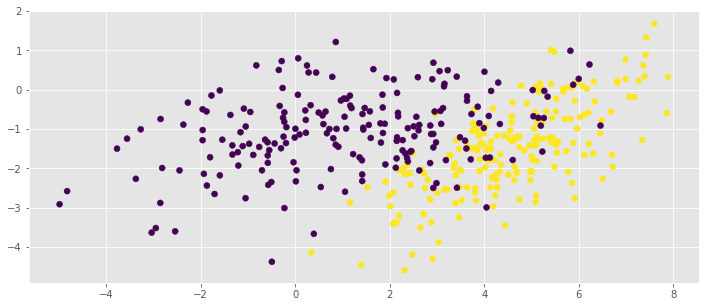

In [6]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:,0], X[:,1], c=y)

In [7]:
model = MySGDClassifier(C=200, alpha=0.01, batch_size=10, max_epoch=300)
model.fit(X, y)

MySGDClassifier(C=200, alpha=0.01, batch_size=10, max_epoch=300)

weights: [-0.48411085  0.33757574  1.50773333]


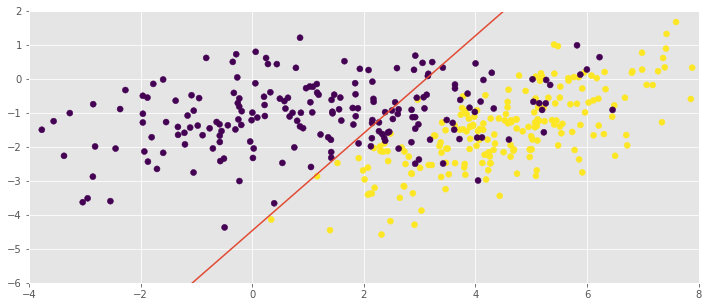

In [8]:
## Your Code Here
print "weights:",model.w
plt.plot ([-4,8], [(4 * model.w[0] - model.w[2]) / model.w[1], (-8* model.w[0] - model.w[2]) / model.w[1]])
plt.scatter(X[:,0], X[:,1], c=y)
axes = plt.gca()
axes.set_xlim([-4,8])
axes.set_ylim([-6,2])
plt.show ()

## Анализ сходимости (2 балл)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

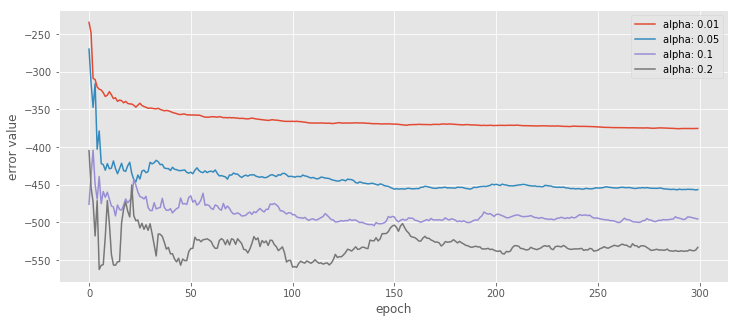

In [9]:
## Your Code Here
for alpha in (0.01, 0.05, 0.1, 0.2):
    model = MySGDClassifier(alpha=alpha, max_epoch=300, C=200, batch_size=10)
    model.fit(X, y)
    plt.plot(model.errors, label='alpha: ' + str(alpha))
plt.ylabel('error value')
plt.xlabel('epoch')
plt.legend()

# Введение в конкурсную задачу

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

### Правила
* Объединяться в команды по правилам конкурса можно, но по правилам нашего курса - нельзя)
* Вы можете использовать любой алгоритм, даже неизученный в нашем курсе (если на защите сможете объяснить как он работает)
* Имейте ввиду, что вы должны отправить результаты строго до 14 мая 23:59 GMT на сайт соревнования (раздел submission). Без результата в leaderboard оценка выставлена не будет.

## Данные

Для того, чтобы получить данные необходимо зарегистрироваться на сайте соревнования. 

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


Данные поставляются в двух форматах:
* В формате json содержится полная информация по текущему состоянию раунда
* В табличном формате упрощенная аггрерированная информация по текущему состоянию раунда

В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если данные не будут помещаться вам с оперативную память, рекомендуется совершить предобработку в python, а  моделирование выполнять с помощью [vowpal wabbit](https://github.com/JohnLangford/vowpal_wabbit).

In [10]:
# Загрузка данных целиком
# df_list = []
# for chunk in range(1,5):
#     filepath = './trainingData_tabular_chunk%d.csv' % chunk
#     df_list.append(pd.read_csv(filepath, sep=','))

# df_data = pd.concat(df_list)

# Загрузка одной части данных
filepath = './trainingData_tabular_chunk1.csv'
df_data = pd.read_csv(filepath, sep=',')

In [11]:
df_data.shape

(500000, 45)

In [12]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [13]:
df_data.head().T

gamestate_id,4687346,3270826,3189487,4098946,2661127
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1


In [14]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

0.504702

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы

In [15]:
## Youd Code Here
opponent_unique_cards = df_data.opponent_hero_card_id.unique()
player_unique_cards = df_data.player_hero_card_id.unique()

print "unique opponent cards: ", len(opponent_unique_cards)
print "unique player cards: ", len(player_unique_cards)

unique opponent cards:  9
unique player cards:  9


In [16]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

player_values_test = enc.fit_transform(
    df_data.player_hero_card_id.values.reshape(-1, 1)).toarray().astype(int)

opponent_values_test = OneHotEncoder().fit_transform(
    df_data.opponent_hero_card_id.values.reshape(-1, 1)).toarray().astype(int)

player_columns = ["player_hero_card_id_" + "%d" % n for n in xrange(1, player_unique_cards.shape[0] + 1)]
opponent_columns = ["opponent_hero_card_id_" + "%d" % n for n in xrange(1, opponent_unique_cards.shape[0] + 1)]
df_train_data = pd.concat([df_data,
                           pd.DataFrame(player_values_test, columns=player_columns,
                                        index=df_data.index),
                           pd.DataFrame(opponent_values_test, columns=opponent_columns,
                                        index=df_data.index)],
                           axis=1)

df_train_data.drop(['opponent_hero_card_id', 'player_hero_card_id'], axis=1, inplace=True)

In [17]:
df_train_data.head().T

gamestate_id,4687346,3270826,3189487,4098946,2661127
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1
opponent_deck_count,11,19,22,17,12


## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Обучите модуль из первой части этого ДЗ на данных

In [18]:
## Youd Code Here
X = df_train_data.drop ('decision', axis=1)
y = df_train_data.decision.values

model = MySGDClassifier(alpha=0.1, max_epoch=10, C=200, batch_size=10)
model.fit (X, y)
print model.w

/home/nastya/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
/home/nastya/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log
/home/nastya/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars


[-0.19167614  2.06454318  0.77704238  6.0399269   0.81715042  1.21184903
 -0.13161248 -1.48739133 -0.28762591  0.74604127  3.74864085 -0.10691243
 -0.24057049  2.58922251 -7.01980805  1.40040588  2.02490528  0.09367132
  1.18427522  0.70981794  0.74604127  0.77746999  0.0925943  -0.10691243
 -1.17723781  2.35929079  2.41583837  1.85303127  0.0925943   0.14773021
 -0.83011657 -4.06325539 -0.1732514   0.53658662  0.65403137  1.07893455
  0.77746999  0.8296796   0.47120694 -1.85920336  0.47887957  0.45391157
  0.28334283  0.53388716  1.0164108   0.31381684  0.97174012  0.89261188
  1.03863427  1.17623851  1.08955911  1.14578227  0.48626813 -0.42267939
  1.49716573  1.09976899  0.28455715  0.63540063  0.86477137  0.71226378]


In [19]:
zip(model.w, X.columns)

[(-0.19167614014032702, 'turn'),
 (2.0645431822923808, 'opponent_armor'),
 (0.77704237631587481, 'opponent_attack'),
 (6.0399268957203356, 'opponent_hp'),
 (0.81715042284122419, 'opponent_special_skill_used'),
 (1.2118490253946597, 'opponent_weapon_durability'),
 (-0.13161248426878824, 'opponent_crystals_all'),
 (-1.4873913313906151, 'opponent_crystals_current'),
 (-0.28762591267710103, 'opponent_deck_count'),
 (0.7460412736291635, 'opponent_fatigue_damage'),
 (3.7486408497207142, 'opponent_hand_count'),
 (-0.10691243050595858, 'opponent_played_minions_count'),
 (-0.2405704875665434, 'player_armor'),
 (2.5892225099033297, 'player_attack'),
 (-7.0198080514149073, 'player_hp'),
 (1.4004058768482464, 'player_special_skill_used'),
 (2.0249052800164842, 'player_weapon_durability'),
 (0.093671322749071848, 'player_crystals_all'),
 (1.1842752191136079, 'player_crystals_current'),
 (0.70981794417571831, 'player_deck_count'),
 (0.7460412736291635, 'player_fatigue_damage'),
 (0.7774699948602225,

## Применение модели (3 балла)
#### Задание
* Загрузите тестовые данные
* Выполните те же операции с датасетом, что и с обучающей выборкой
* Примените модель и загрузите решение на страницу конкурса
* Напечатайте ваш ник и оценку качества, полученную после загрузки

Судя по описанию, submission file должен состоять из одного столбца с числами, соответствующим вероятностям победы игрока.

In [20]:
## Youd Code Here
filepath = 'testData_tabular.csv'
df_test_data = pd.read_csv(filepath, sep=',')

In [21]:
df_test_data.shape

(750000, 45)

In [24]:
# для удобства
df_test_data.columns = df_test_data.columns.str.replace('.', '_')
df_test_data = df_test_data.set_index('gamestate_id')

KeyError: 'gamestate_id'

In [26]:
df_test_data.head().T

gamestate_id,6845857.0,9279433.0,6642076.0,9169516.0,8991397.0
decision,NaN,NaN,NaN,NaN,NaN
turn,12.0,6.0,14.0,7.0,9.0
opponent_armor,0.0,0.0,0.0,0.0,0.0
opponent_attack,0.0,0.0,0.0,0.0,0.0
opponent_hero_card_id,798.0,326.0,390.0,798.0,326.0
opponent_hp,29.0,12.0,12.0,30.0,30.0
opponent_special_skill_used,1.0,0.0,0.0,0.0,1.0
opponent_weapon_durability,0.0,0.0,0.0,0.0,0.0
opponent_crystals_all,10.0,5.0,10.0,6.0,8.0
opponent_crystals_current,8.0,5.0,0.0,6.0,2.0


In [27]:
opponent_unique_cards = df_test_data.opponent_hero_card_id.unique ()
player_unique_cards = df_test_data.player_hero_card_id.unique ()

enc = OneHotEncoder()
player_values_test = enc.fit_transform(
    df_test_data.player_hero_card_id.values.reshape(-1, 1)).toarray().astype(int)

opponent_values_test = OneHotEncoder().fit_transform(
    df_test_data.opponent_hero_card_id.values.reshape(-1, 1)).toarray().astype(int)

player_columns = ["player_hero_card_id_" + "%d" % n for n in xrange(1, player_unique_cards.shape[0] + 1)]
opponent_columns = ["opponent_hero_card_id_" + "%d" % n for n in xrange(1, opponent_unique_cards.shape[0] + 1)]
df_test_modified_data = pd.concat([df_test_data,
                           pd.DataFrame(player_values_test, columns=player_columns,
                                        index=df_test_data.index),
                           pd.DataFrame(opponent_values_test, columns=opponent_columns,
                                        index=df_test_data.index)],
                           axis=1)

df_test_modified_data.drop(['opponent_hero_card_id', 'player_hero_card_id'], axis=1, inplace=True)

MemoryError: 

In [ ]:
df_test_modified_data.head().T

In [ ]:
X_test = df_test_modified_data.drop ('decision', axis=1)

scores = model.predict_proba(X_test)
scores

In [ ]:
np.savetxt("result_scores.txt", scores, fmt='%.20f')